<a href="https://colab.research.google.com/github/ulung3ko/deep-learning-assignment-hyperparameter-tuning/blob/main/uts_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install yahoofinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38618 sha256=98fe144b455804583e322795ce1a047172dd6bf3227d7ff81474370d7094d096
  Stored in directory: /root/.cache/pip/wheels/c6/bc/18/da12b3c280d31beeac0c0f491c8f370da7c1473a56d7d4b5f3
Successfully built yahoofinancials


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import yfinance as yf
from yahoofinancials import YahooFinancials

In [ ]:
samsung_df = yf.download('005930.KS',
                      start='2018-12-31',
                      end='2025-05-29',
                      progress=False,
)
print(samsung_df.head())

YF.download() has changed argument auto_adjust default to True
Price              Close          High           Low          Open    Volume
Ticker         005930.KS     005930.KS     005930.KS     005930.KS 005930.KS
Date                                                                        
2019-01-02  32866.578125  33417.888468  32696.944173  33417.888468   7847664
2019-01-03  31891.185547  32696.946884  31763.960073  32484.904427  12471493
2019-01-04  31763.958984  31891.184454  31255.057105  31763.958984  14108958
2019-01-07  32866.578125  32993.803589  32060.816855  32230.450806  12748997
2019-01-08  32315.265625  33248.252297  32188.040170  32230.448655  12756554


In [ ]:
samsung_df.info()
print(samsung_df.columns)
print(samsung_df.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1572 entries, 2019-01-02 to 2025-05-28
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Close, 005930.KS)   1572 non-null   float64
 1   (High, 005930.KS)    1572 non-null   float64
 2   (Low, 005930.KS)     1572 non-null   float64
 3   (Open, 005930.KS)    1572 non-null   float64
 4   (Volume, 005930.KS)  1572 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 73.7 KB
MultiIndex([( 'Close', '005930.KS'),
            (  'High', '005930.KS'),
            (   'Low', '005930.KS'),
            (  'Open', '005930.KS'),
            ('Volume', '005930.KS')],
           names=['Price', 'Ticker'])
DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2025-05-15', '2025-05-16', '202

In [ ]:
samsung_df.columns = samsung_df.columns.get_level_values(0)
print(samsung_df.columns.tolist())
print(samsung_df.head())
print(f"Tipe Index Tanggal: {type(samsung_df.index)}, Nama Index: {samsung_df.index.name}, Tipe Data Index: {samsung_df.index.dtype}")

['Close', 'High', 'Low', 'Open', 'Volume']
Price              Close          High           Low          Open    Volume
Date                                                                        
2019-01-02  32866.578125  33417.888468  32696.944173  33417.888468   7847664
2019-01-03  31891.185547  32696.946884  31763.960073  32484.904427  12471493
2019-01-04  31763.958984  31891.184454  31255.057105  31763.958984  14108958
2019-01-07  32866.578125  32993.803589  32060.816855  32230.450806  12748997
2019-01-08  32315.265625  33248.252297  32188.040170  32230.448655  12756554
Tipe Index Tanggal: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>, Nama Index: Date, Tipe Data Index: datetime64[ns]


In [ ]:
print(samsung_df.describe().transpose())

         count          mean           std           min           25%  \
Price                                                                    
Close   1572.0  5.943402e+04  1.256832e+04  31763.958984  5.125138e+04   
High    1572.0  6.001952e+04  1.267016e+04  31891.184454  5.172317e+04   
Low     1572.0  5.891485e+04  1.250773e+04  31255.057105  5.063822e+04   
Open    1572.0  5.947665e+04  1.261030e+04  31763.958984  5.118813e+04   
Volume  1572.0  1.663015e+07  8.670203e+06      0.000000  1.129879e+07   

                 50%           75%           max  
Price                                             
Close   5.909488e+04  7.019967e+04  8.620664e+04  
High    5.976208e+04  7.063847e+04  8.843123e+04  
Low     5.844766e+04  6.963404e+04  8.551934e+04  
Open    5.929105e+04  7.032381e+04  8.689393e+04  
Volume  1.479934e+07  2.001014e+07  9.030618e+07  


In [ ]:
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
target_column = 'Close'

data_to_process = samsung_df[feature_columns].copy()
print(f"Fitur yang digunakan: {feature_columns}")
print(f"Target prediksi: {target_column}")
print("Shape data_to_process:", data_to_process.shape)

Fitur yang digunakan: ['Open', 'High', 'Low', 'Close', 'Volume']
Target prediksi: Close
Shape data_to_process: (1572, 5)


In [ ]:
total_data_len = len(data_to_process)
train_split_ratio = 0.7
val_split_ratio = 0.15

train_len = int(total_data_len * train_split_ratio)
val_len = int(total_data_len * val_split_ratio)

train_data = data_to_process.iloc[:train_len]
val_data = data_to_process.iloc[train_len : train_len + val_len]
test_data = data_to_process.iloc[train_len + val_len :]

print(f"Data keseluruhan: {total_data_len}")
print(f"Data pelatihan: {len(train_data)}")
print(f"Data validasi: {len(val_data)}")
print(f"Data pengujian: {len(test_data)}")

Data keseluruhan: 1572
Data pelatihan: 1100
Data validasi: 235
Data pengujian: 237


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)

train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

target_col_index = feature_columns.index(target_column)

In [ ]:
def create_sequences(data_scaled, time_steps_param, target_col_idx_param):
    X_list, y_list = [], []
    for i in range(time_steps_param, len(data_scaled)):
        X_list.append(data_scaled[i - time_steps_param:i, :])
        y_list.append(data_scaled[i, target_col_idx_param])
    return np.array(X_list), np.array(y_list)

TIME_STEPS = 60

X_train, y_train = create_sequences(train_scaled, TIME_STEPS, target_col_index)
X_val, y_val = create_sequences(val_scaled, TIME_STEPS, target_col_index)
X_test, y_test = create_sequences(test_scaled, TIME_STEPS, target_col_index)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

time_steps_model = X_train.shape[1]
num_features_model = X_train.shape[2]
print(f"Time steps untuk model: {time_steps_model}, Jumlah Fitur: {num_features_model}")

model_results = {}

X_train: (1040, 60, 5), y_train: (1040,)
X_val: (175, 60, 5), y_val: (175,)
X_test: (177, 60, 5), y_test: (177,)
Time steps untuk model: 60, Jumlah Fitur: 5


In [ ]:
def create_lstm_model(input_shape_param):
    model = Sequential(name="LSTM_Model")
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape_param))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = create_lstm_model((time_steps_model, num_features_model))

In [ ]:
def create_gru_model(input_shape_param):
    model = Sequential(name="GRU_Model")
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape_param))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

gru_model = create_gru_model((time_steps_model, num_features_model))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0695 - val_loss: 0.0095
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0037 - val_loss: 0.0065
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0033 - val_loss: 0.0053
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0032 - val_loss: 0.0059
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0028 - val_loss: 0.0130
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.

In [ ]:
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0704 - val_loss: 0.0011
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0026 - val_loss: 0.0044


In [ ]:
predictions_scaled_lstm = lstm_model.predict(X_test)

y_test_inverse_dummy = np.zeros((len(y_test), num_features_model))
y_test_inverse_dummy[:, target_col_index] = y_test.ravel()
y_test_actual = scaler.inverse_transform(y_test_inverse_dummy)[:, target_col_index]

predictions_inverse_dummy_lstm = np.zeros((len(predictions_scaled_lstm), num_features_model))
predictions_inverse_dummy_lstm[:, target_col_index] = predictions_scaled_lstm.ravel()
predictions_lstm = scaler.inverse_transform(predictions_inverse_dummy_lstm)[:, target_col_index]

rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, predictions_lstm))
mae_lstm = mean_absolute_error(y_test_actual, predictions_lstm)

model_results['LSTM'] = {
    'RMSE': rmse_lstm,
    'MAE': mae_lstm,
    'Predictions': predictions_lstm,
    'History': history_lstm
}

print(f"Hasil Evaluasi LSTM:")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAE: {mae_lstm:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Hasil Evaluasi LSTM:
RMSE: 2626.45
MAE: 2013.89


In [ ]:
predictions_scaled_gru = gru_model.predict(X_test)

predictions_inverse_dummy_gru = np.zeros((len(predictions_scaled_gru), num_features_model))
predictions_inverse_dummy_gru[:, target_col_index] = predictions_scaled_gru.ravel()
predictions_gru = scaler.inverse_transform(predictions_inverse_dummy_gru)[:, target_col_index]

rmse_gru = np.sqrt(mean_squared_error(y_test_actual, predictions_gru))
mae_gru = mean_absolute_error(y_test_actual, predictions_gru)

model_results['GRU'] = {
    'RMSE': rmse_gru,
    'MAE': mae_gru,
    'Predictions': predictions_gru,
    'History': history_gru
}

print(f"Hasil Evaluasi GRU:")
print(f"RMSE: {rmse_gru:.2f}")
print(f"MAE: {mae_gru:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Hasil Evaluasi GRU:
RMSE: 3124.41
MAE: 2705.07


In [ ]:
results_summary = []
for name, metrics_dict in model_results.items():
    results_summary.append({
        'Model': name,
        'RMSE': metrics_dict['RMSE'],
        'MAE': metrics_dict['MAE'],
    })
results_df = pd.DataFrame(results_summary)

print(results_df.to_string())

  Model         RMSE          MAE
0  LSTM  2626.453883  2013.893616
1   GRU  3124.412636  2705.065372


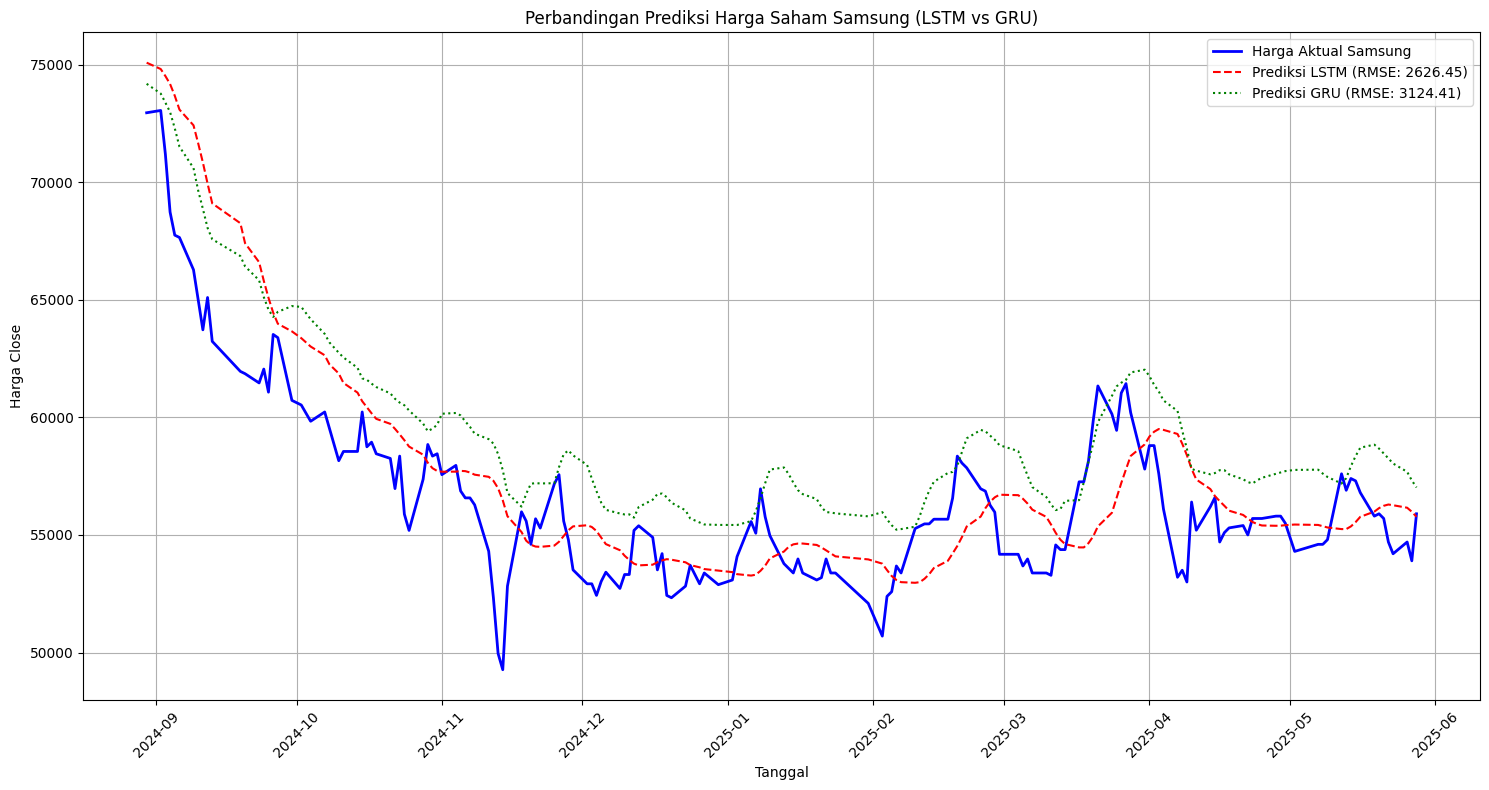

In [ ]:
plot_dates = test_data.index[TIME_STEPS : TIME_STEPS + len(y_test_actual)]

plt.figure(figsize=(15, 8))
plt.plot(plot_dates, y_test_actual, color='blue', label='Harga Aktual Samsung', linewidth=2)

if 'LSTM' in model_results:
    plt.plot(plot_dates, model_results['LSTM']['Predictions'], color='red', linestyle='--',
             label=f"Prediksi LSTM (RMSE: {model_results['LSTM']['RMSE']:.2f})")
if 'GRU' in model_results:
    plt.plot(plot_dates, model_results['GRU']['Predictions'], color='green', linestyle=':',
             label=f"Prediksi GRU (RMSE: {model_results['GRU']['RMSE']:.2f})")

plt.title('Perbandingan Prediksi Harga Saham Samsung (LSTM vs GRU)')
plt.xlabel('Tanggal')
plt.ylabel(f'Harga {target_column}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

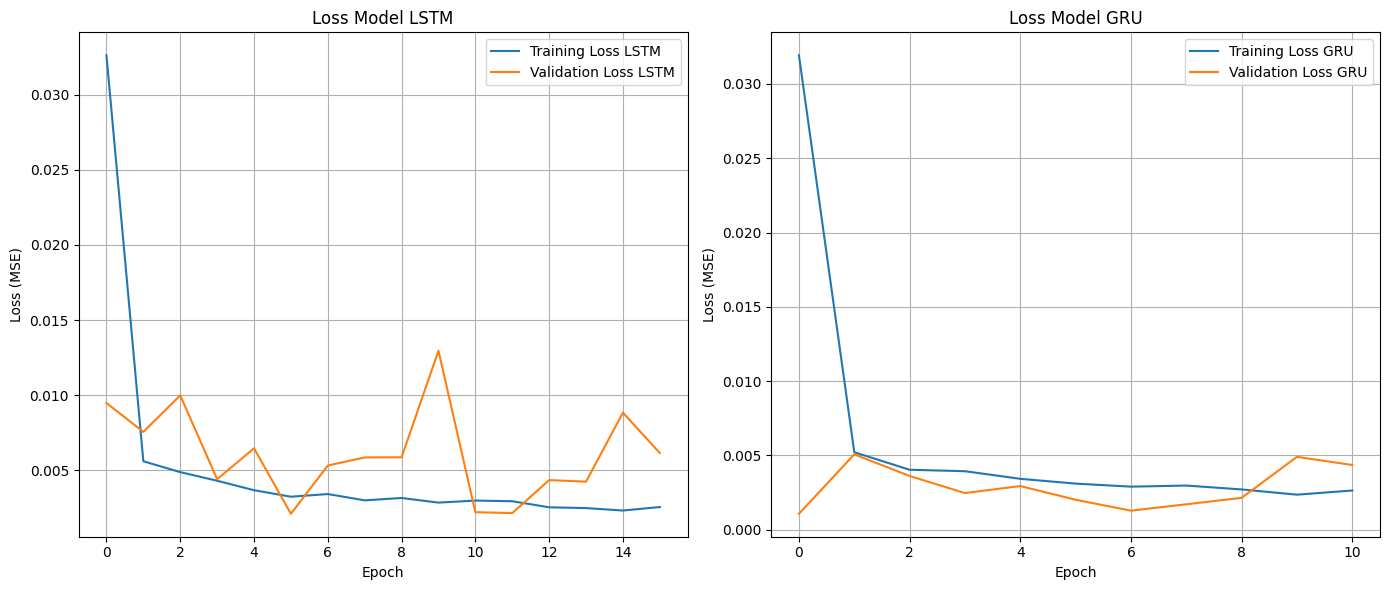

In [ ]:
num_models_to_plot = len(model_results)
if num_models_to_plot > 0:
    plt.figure(figsize=(7 * num_models_to_plot, 6))

    plot_idx_counter = 1
    if 'LSTM' in model_results:
        plt.subplot(1, num_models_to_plot, plot_idx_counter)
        plt.plot(model_results['LSTM']['History'].history['loss'], label='Training Loss LSTM')
        plt.plot(model_results['LSTM']['History'].history['val_loss'], label='Validation Loss LSTM')
        plt.title('Loss Model LSTM')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plot_idx_counter += 1

    if 'GRU' in model_results:
        plt.subplot(1, num_models_to_plot, plot_idx_counter)
        plt.plot(model_results['GRU']['History'].history['loss'], label='Training Loss GRU')
        plt.plot(model_results['GRU']['History'].history['val_loss'], label='Validation Loss GRU')
        plt.title('Loss Model GRU')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada hasil model untuk membuat plot kurva loss.")